In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from xgboost import XGBClassifier


In [2]:
df = pd.read_csv("creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df['Class'].value_counts()


Class
0    284315
1       492
Name: count, dtype: int64

In [4]:
X = df.drop("Class", axis=1)
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [5]:
iso = IsolationForest(contamination=0.0017, random_state=42)
y_pred_iso = iso.fit_predict(X_train)

y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print(confusion_matrix(y_train, y_pred_iso))


[[227177    274]
 [   280    114]]


In [7]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017)
y_pred_lof = lof.fit_predict(X_train)

y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

print(confusion_matrix(y_train, y_pred_lof))


[[227063    388]
 [   394      0]]


In [8]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight= len(y_train[y_train==0]) / len(y_train[y_train==1])
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [9]:
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:,1]


In [10]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[56853    11]
 [   16    82]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



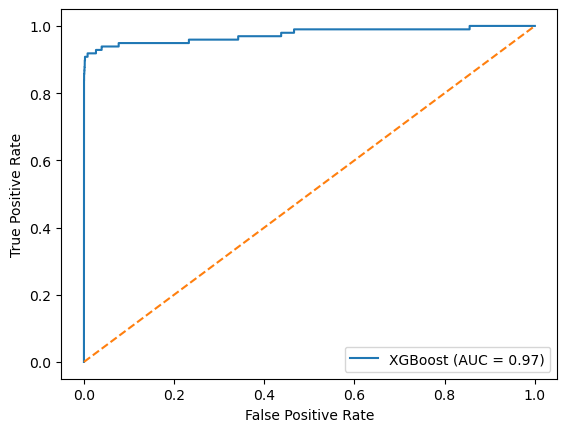

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label="XGBoost (AUC = %0.2f)" % roc_auc)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [14]:
import joblib

joblib.dump(xgb, "models/xgb_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")


['models/scaler.pkl']

In [15]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [16]:
import streamlit as st
import joblib
import numpy as np

model = joblib.load("models/xgb_model.pkl")
scaler = joblib.load("models/scaler.pkl")

st.title("💳 Credit Card Fraud Detection")

amount = st.number_input("Transaction Amount")
time = st.number_input("Transaction Time")

if st.button("Predict"):
    features = np.zeros((1,30))
    features[0][0] = time
    features[0][1] = amount

    features = scaler.transform(features)

    prediction = model.predict(features)

    if prediction == 1:
        st.error("⚠️ Fraudulent Transaction")
    else:
        st.success("✅ Legit Transaction")


2026-02-17 21:17:55.408 
  command:

    streamlit run C:\Users\SRIKANTH\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [19]:
streamlit run C:\Users\SRIKANTH\anaconda3\Lib\site-packages\ipykernel_launcher.py

SyntaxError: invalid syntax (1633653222.py, line 1)